In [1]:
!pip install transformers
!pip install simpletransformers

     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 3.3MB 48.3MB/s 
     |████████████████████████████████| 901kB 56.1MB/s 
     |████████████████████████████████| 225kB 8.4MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 1.2MB 67.0MB/s 
     |████████████████████████████████| 122kB 71.9MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 8.2MB 62.7MB/s 
     |████████████████████████████████| 1.8MB 41.4MB/s 
     |████████████████████████████████| 235kB 66.3MB/s 
     |████████████████████████████████| 112kB 58.5MB/s 
     |████████████████████████████████| 4.2MB 61.7MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 174kB 71.9MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 133kB 49.6MB/s 
     |████████████████████████████████| 245kB 67.9MB/s

In [29]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import sklearn
# import ipdb


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

from simpletransformers.classification import ClassificationModel, ClassificationArgs
from simpletransformers.classification import (
    MultiLabelClassificationModel, MultiLabelClassificationArgs
)

import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
import logging

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [30]:
documents_train = pd.read_csv("/content/drive/MyDrive/round1/data_round_1/documents_en_train.csv")
sentences_train = pd.read_csv("/content/drive/MyDrive/round1/data_round_1/sentences_en_train.csv")

documents_val = pd.read_csv("/content/drive/MyDrive/round1/data_round_1/documents_en_val.csv")
sentences_val = pd.read_csv("/content/drive/MyDrive/round1/data_round_1/sentences_en_val.csv")

documents_test = pd.read_csv("/content/drive/MyDrive/round1/data_round_1/documents_en_test.csv")
sentences_test = pd.read_csv("/content/drive/MyDrive/round1/data_round_1/sentences_en_test.csv")

In [ ]:
documents_train = pd.read_csv("data_round_1/documents_en_train.csv")
sentences_train = pd.read_csv("data_round_1/sentences_en_train.csv")

documents_val = pd.read_csv("data_round_1/documents_en_val.csv")
sentences_val = pd.read_csv("data_round_1/sentences_en_val.csv")

documents_test = pd.read_csv("data_round_1/documents_en_test.csv")
sentences_test = pd.read_csv("data_round_1/sentences_en_test.csv")
#immap_sector_name_to_id.json

In [31]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [32]:
device

device(type='cuda')

## Investigate Document data

In [7]:
documents_train.head()

,project_name,country_code,lang_code,doc_id,doc_text,doc_url
0,IMMAP/DFS Syria,SYR,en,48582,This website uses cookies to improve your expe...,https://www.syriahr.com/en/203844/
1,IMMAP/DFS Syria,SYR,en,41032,Please enable Cookies and reload the page.\n\n...,https://www.syriahr.com/en/187230/
2,IMMAP/DFS Burkina Faso,BFA,en,41306,When Burkina Faso’s government called for civi...,https://www.thenewhumanitarian.org/news-featur...
3,IMMAP/DFS Syria,SYR,en,43779,DAMASCUS – The United Nations World Food Progr...,https://reliefweb.int/report/syrian-arab-repub...
4,IMMAP/DFS Nigeria,NGA,en,42212,Overview The continuation of conflict in North...,https://reliefweb.int/sites/reliefweb.int/file...


## Investigate full text data

In [8]:
sentences_train.head()

,doc_id,sentence_id,sentence_text,is_relevant,sector_ids
0,51657,0,New Salesian youth center in La Cecilia distri...,0,[]
1,51657,1,Armenia is at the center of the Colombian coff...,0,[]
2,51657,2,The new youth center has served more than 100 ...,0,[]
3,51657,3,The Salesian youth center was developed in res...,0,[]
4,51657,4,Many of these youth come from poor families an...,0,[]


In [9]:
counts = sentences_train[["sentence_id", "doc_id"]].groupby("doc_id").count()
print("Median sentence lenght of document:", np.median(counts))
counts

Median sentence lenght of document: 24.0


,sentence_id
doc_id,
34512,126
34513,296
34547,750
34549,65
34550,36
...,...
51845,4
51850,22
51851,3


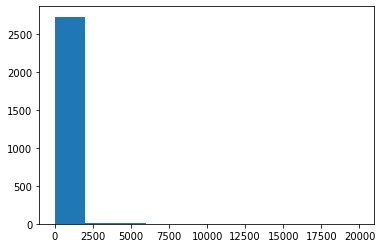

In [10]:
import matplotlib.pyplot as plt
counts = sentences_train.groupby("doc_id").count()
x = counts["sentence_id"]
plt.hist(x)
plt.show()

In [11]:
all_sectors = []
string_list = ["[", "]", ",", " "]
for topics in sentences_train["sector_ids"]:
    for topic in topics:
        if topic not in string_list:
            all_sectors.append(topic)        

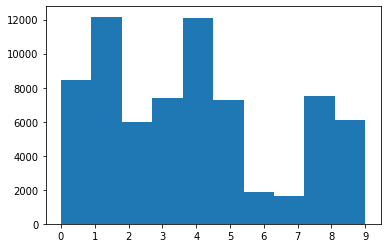

In [12]:
plt.hist(sorted(all_sectors))
plt.show()

In [13]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [14]:
sentences_train['sentence_text']

0         New Salesian youth center in La Cecilia distri...
1         Armenia is at the center of the Colombian coff...
2         The new youth center has served more than 100 ...
3         The Salesian youth center was developed in res...
4         Many of these youth come from poor families an...
                                ...                        
261976    However, humanitarian exemptions are not alway...
261977    In Iraq, there are reports of exemptions from ...
261978    The ACAPS team will keep monitoring the impact...
261979    You can find an overview of all ACAPS resource...
261980    11 ACAPS HUMANITARIAN ACCESS OVERVIEW JULY 202...
Name: sentence_text, Length: 261981, dtype: object

In [ ]:
train_df = pd.DataFrame({
    'text': sentences_train['sentence_text'],
    'label': sentences_train["is_relevant"]
})

In [ ]:
eval_df = pd.DataFrame({
    'text': sentences_val['sentence_text'],
    'label': sentences_val["is_relevant"],
})

In [ ]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=1)

In [ ]:
# Create a TransformerModel
model = ClassificationModel('distilbert', 'distilbert-base-uncased', use_cuda=False)

In [ ]:
# Train the model
model.train_model(train_df, overwrite_output_dir=True)

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [ ]:
result

In [ ]:
predictions, raw_outputs = model.predict(sentences_test['sentence_text'].astype(str).values.tolist())

In [ ]:
len(predictions)

In [ ]:
submit_df = pd.DataFrame({
    'doc_id': sentences_test['doc_id'],
    'sentence_id': sentences_test["sentence_id"],
    'is_relevant': predictions,
})

In [ ]:
submit_df.to_csv("submissions/submission_relevant_baseline", index=False)

### Multi-Label Classification

In [33]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [34]:
sentences_train = sentences_train.loc[sentences_train["is_relevant"] == 1]
sentences_val = sentences_val.loc[sentences_val["is_relevant"] == 1]

In [35]:
def process_sector_ids(sentences):
    mlb = MultiLabelBinarizer()
    sectors = pd.DataFrame(mlb.fit_transform(sentences["sector_ids"]),columns=mlb.classes_)
    sectors = sectors.drop([",", "[", "]", " "], axis = 1)
    sectors["-1"] = 0
    sectors["-1"][sectors.sum(axis=1) == 0] = 1

    return sectors.values

In [36]:
train_labels = process_sector_ids(sentences_train)
val_labels = process_sector_ids(sentences_val)

In [37]:
train_labels = pd.DataFrame(train_labels)
val_labels = pd.DataFrame(val_labels)

In [38]:
sentences_train = sentences_train.reset_index()
sentences_val = sentences_val.reset_index()

In [39]:
sentences_train['labels'] = train_labels.apply(lambda x: [np.array(x)], axis=1).apply(lambda x: x[0])
sentences_val['labels'] = val_labels.apply(lambda x: [np.array(x)], axis=1).apply(lambda x: x[0])

In [22]:
sentences_train

,index,doc_id,sentence_id,sentence_text,is_relevant,sector_ids,labels
0,14,51657,14,One in five children in the country has no acc...,1,"[2, 5]","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
1,15,51657,15,Many orphaned youth live in poverty and have l...,1,"[2, 5]","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
2,16,51657,16,Some children remain living with a single pare...,1,"[2, 5]","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
3,17,51657,17,Other youth live in shelters or on the streets.,1,"[2, 5]","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
4,19,51542,0,WFP Colombia Country Brief December 2020 Opera...,1,[3],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...
41890,261836,34549,46,Anticipatory action is critical to safeguard t...,1,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
41891,261841,34549,51,Cash+ in the form of cash transfers and provis...,1,[0],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
41892,261842,34549,52,The focus of this intervention is to support v...,1,[0],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
41893,261843,34549,53,Cash+ in the form of cash transfers and provis...,1,[8],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


In [40]:
sentences_train = sentences_train[['sentence_text', 'labels']].copy()
sentences_val = sentences_val[['sentence_text', 'labels']].copy()

In [41]:
sentences_train.columns = ["text", "labels"]
sentences_val.columns = ["text", "labels"]

In [49]:
model_args.num_train_epochs=10

In [50]:
# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel(
    "roberta", "roberta-base", num_labels=11, args=model_args, use_cuda=True
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias',

In [47]:
sentences_train

,text,labels
0,One in five children in the country has no acc...,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
1,Many orphaned youth live in poverty and have l...,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
2,Some children remain living with a single pare...,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
3,Other youth live in shelters or on the streets.,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]"
4,WFP Colombia Country Brief December 2020 Opera...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
41890,Anticipatory action is critical to safeguard t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
41891,Cash+ in the form of cash transfers and provis...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
41892,The focus of this intervention is to support v...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
41893,Cash+ in the form of cash transfers and provis...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"


In [51]:
# Train the model
model.train_model(sentences_train, overwrite_output_dir=True)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/41895 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_0_2


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/5237 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/5237 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/5237 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/5237 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/5237 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/5237 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/5237 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/5237 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/5237 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/5237 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


(52370, 0.14356737713621276)

In [52]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(
    sentences_val
)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4927 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_0_2


Running Evaluation:   0%|          | 0/616 [00:00<?, ?it/s]

In [54]:
result

{'LRAP': 0.8011884881183821, 'eval_loss': 0.3093181574016404}

In [55]:
# Make predictions with the model
predictions, raw_outputs = model.predict(sentences_test['sentence_text'].astype(str).values.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/56689 [00:00<?, ?it/s]

  0%|          | 0/7087 [00:00<?, ?it/s]

In [59]:
predictions = pd.DataFrame({'labels':predictions})

In [61]:
predictions.to_csv("predictions_multi_label_roBERTa.csv")

In [62]:
!zip -r /content/outputs/

  adding: content/outputs/ (stored 0%)
  adding: content/outputs/checkpoint-42000/ (stored 0%)
  adding: content/outputs/checkpoint-42000/special_tokens_map.json (deflated 83%)
  adding: content/outputs/checkpoint-42000/merges.txt (deflated 53%)
  adding: content/outputs/checkpoint-42000/vocab.json (deflated 63%)
  adding: content/outputs/checkpoint-42000/model_args.json (deflated 62%)
  adding: content/outputs/checkpoint-42000/scheduler.pt (deflated 49%)
  adding: content/outputs/checkpoint-42000/tokenizer_config.json (deflated 72%)
  adding: content/outputs/checkpoint-42000/optimizer.pt (deflated 26%)
  adding: content/outputs/checkpoint-42000/config.json (deflated 57%)
  adding: content/outputs/checkpoint-42000/training_args.bin (deflated 49%)
  adding: content/outputs/checkpoint-42000/pytorch_model.bin (deflated 12%)
  adding: content/outputs/checkpoint-8000/ (stored 0%)
  adding: content/outputs/checkpoint-8000/special_tokens_map.json (deflated 83%)
  adding: content/outputs/check

In [63]:
from google.colab import files
files.download("/content/outputs/.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def hamming_score(y_true, y_pred):
    # https://link.springer.com/chapter/10.1007/978-3-540-24775-3_5
    # please check the source: https://github.com/varunshenoy/simple-metrics/blob/master/simple-metrics.py
    acc_list = []
    for yt, yp in zip(y_true, y_pred):
        set_true = set(yt)
        set_pred = set(yp)
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true & set_pred) / len(set_true | set_pred)
        acc_list.append(tmp_a)
    return np.mean(acc_list)